In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_curve, roc_auc_score
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [22]:
!git clone https://github.com/Qertal/projekt_raw.git

Klonowanie do „projekt_raw”...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0
Pobieranie obiektów: 100% (3/3), 16.00 KiB | 546.00 KiB/s, gotowe.


Zaczynamy od wczytania naszych danych z pliku Cardiovascular_Disease_Dataset.csv. Plik został pobrany ze strony kaggle.com, a dokładnie: https://www.kaggle.com/datasets/jocelyndumlao/cardiovascular-disease-dataset. Bedziemy w nim badac to czy pacjent z danymi objawami badz schorzeniami posiada jakas chorobę serca (nie ustalamy jaka)

In [23]:
cardio_dataframe = pd.read_csv('projekt_raw/Cardiovascular_Disease_Dataset.csv')

In [24]:
cardio_dataframe

,patientid,age,gender,chestpain,restingBP,serumcholestrol,fastingbloodsugar,restingrelectro,maxheartrate,exerciseangia,oldpeak,slope,noofmajorvessels,target
0,103368,53,1,2,171,0,0,1,147,0,5.3,3,3,1
1,119250,40,1,0,94,229,0,1,115,0,3.7,1,1,0
2,119372,49,1,2,133,142,0,0,202,1,5.0,1,0,0
3,132514,43,1,0,138,295,1,1,153,0,3.2,2,2,1
4,146211,31,1,1,199,0,0,2,136,0,5.3,3,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,9949544,48,1,2,139,349,0,2,183,1,5.6,2,2,1
996,9953423,47,1,3,143,258,1,1,98,1,5.7,1,0,0
997,9965859,69,1,0,156,434,1,0,196,0,1.4,3,1,1
998,9988507,45,1,1,186,417,0,1,117,1,5.9,3,2,1


1. Numer identyfikacyjny pacjenta (patientid)

2. Wiek w latach (Age)

3. Płeć biologiczna (gender)

4. Rodzaj bólu w klatce piersiowej

- 0 - typowy ból dławicowy
- 1 - nietypowa ból dławicowy
- 2 - ból niedławicowy
- 3 - brak objawów

5. Spoczynkowe cisnienie krwi (restingBP) 94-200 (w mm HG)

6. Cholestor (serumcholestrol) 126-564 (in mg/dl)

7. Cukier (fastingbloodsugar) >120 mg/dl

- 0 - Nie
- 1 = Tak

8. Wyniki spoczynkowego EKG (restingrelectro):

- 0 - w normie
- 1 - z nieprawidłowością załamka ST-T (odwrócenie załamka T i/lub uniesienie lub obniżenie ST > 0,05 mV)
- 2 - wykazujący prawdopodobny lub pewny przerost lewej komory według kryteriów Estesa)

9. Maksymalne osiagniete tętno (maxheartrate) 71-202

10. Dławica pierwsiowa wywołana wysiłkiem fizycznym (exerciseangia)

- 0 - Nie
- 1 - Tak

11. Oldpeak=ST (oldpeak) 0 - 6.2

12. Nachylenie szczytu odcinka ST w trakcie maksylmalnego wysilku fizycznego. (slope)

- 0 -
- 1 - upsloping
- 2 - flat
- 3 - downsloping

13. Liczba dużych naczyń krwionośnych (noofmajorvessels) 0,1,2,3

14. Klasyfikacja (target)

- 0 - Brak chorob serca
- 1 - Obecnosc choroby serca

Sprawdzmy teraz czy posiadamy w zbiorze danych jakies puste komórki

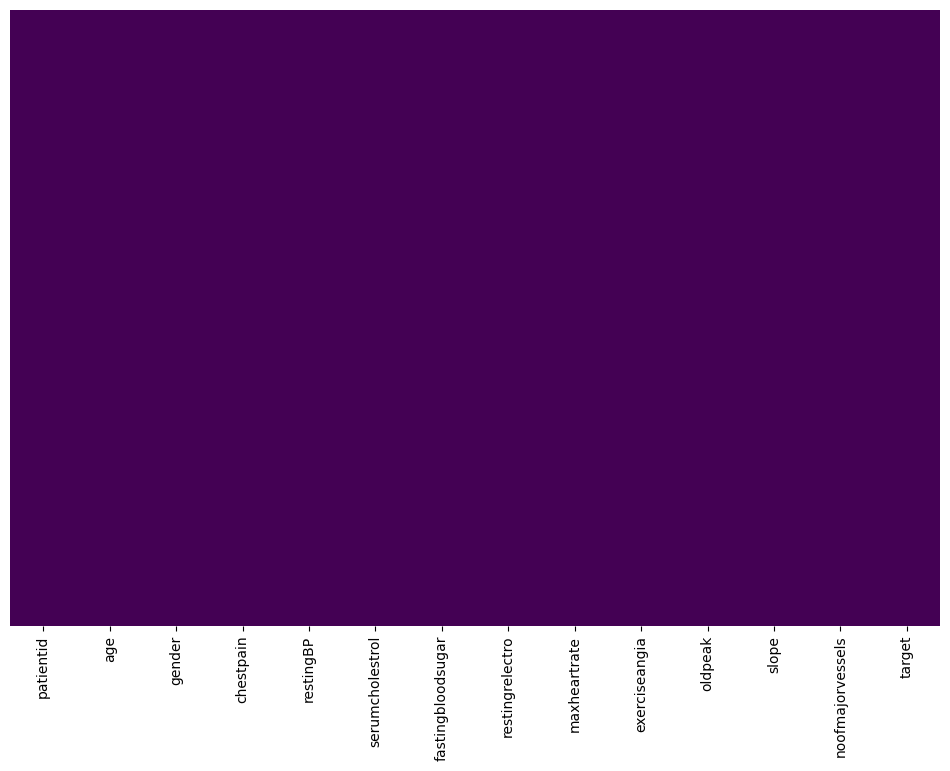

In [25]:
plt.figure(figsize=(12, 8))
sns.heatmap(cardio_dataframe.isnull(),yticklabels=False, cbar=False, cmap='viridis')
plt.show()


Brak pustych komórek, wspaniala informacja. Teraz sprawdzmy czy klasy w kolumnie target sa rownoliczne

target
1    580
0    420
Name: count, dtype: int64

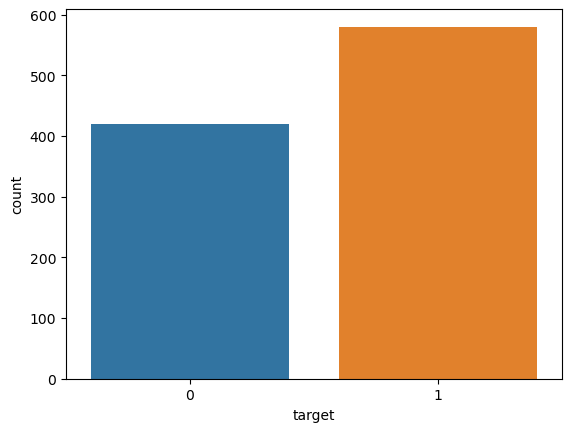

In [26]:
sns.countplot(x=cardio_dataframe['target'])
liczba_wystapien = cardio_dataframe['target'].value_counts()
liczba_wystapien

Mamy delikatna roznice, jednak nie wydaje mi sie zeby ona byla na tyle znaczaca w kontekscie tego modelu. Tak czy tak okaze sie to w trakcie podczas modelowania. Przejdzmy zatem do dalszego przygotowywania naszego datasetu. Spojrzmy na ceche pod nazwa "chestpain".

In [27]:
cardio_dataframe['chestpain'].unique()

array([2, 0, 1, 3])

Tak jak w sumie mielismy na poczatku, w naszej kolumnie chestpain mozemy spotkac sie z 4 roznymi wartosciami, ktore choc na poczatku moga zdawac sie byc numeryczne, tak naprawde sa te zmienne jakosciowe. Musimy cos z nimi zrobic. Najprostszym pomyslem jest uzycie fukcji get_dummies. Rozlozy nam ona ta jedna kolumne na 4 nastepne, gdzie kazda bedzie przyjmowac wartosci 0 - 1. Kazda kolumna odpowiada jednej wartosci z aktualnej tabeli. Dodatkowo skasujemy pierwsza kolumne, no bo wiadomo, jesi bedziemy miec 0 przy kazdej z nowo utworzonych 3 kolumn, to znaczy ze zachodzi sytuacja numer 4

In [28]:
chestpain = pd.get_dummies(cardio_dataframe['chestpain'],drop_first=True,prefix='chestpain_')
chestpain

,chestpain__1,chestpain__2,chestpain__3
0,False,True,False
1,False,False,False
2,False,True,False
3,False,False,False
4,True,False,False
...,...,...,...
995,False,True,False
996,False,False,True
997,False,False,False
998,True,False,False


Dodajemy od razu prefix chestpain, zeby latwiej nam bylo potem ogarnac co to za kolumny w datasecie i przechodzimy do dodania nowych kolumn do naszego zbioru za pomoca concata

In [29]:
cardio_dataframe = pd.concat([cardio_dataframe,chestpain], axis=1)

In [30]:
cardio_dataframe

,patientid,age,gender,chestpain,restingBP,serumcholestrol,fastingbloodsugar,restingrelectro,maxheartrate,exerciseangia,oldpeak,slope,noofmajorvessels,target,chestpain__1,chestpain__2,chestpain__3
0,103368,53,1,2,171,0,0,1,147,0,5.3,3,3,1,False,True,False
1,119250,40,1,0,94,229,0,1,115,0,3.7,1,1,0,False,False,False
2,119372,49,1,2,133,142,0,0,202,1,5.0,1,0,0,False,True,False
3,132514,43,1,0,138,295,1,1,153,0,3.2,2,2,1,False,False,False
4,146211,31,1,1,199,0,0,2,136,0,5.3,3,2,1,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,9949544,48,1,2,139,349,0,2,183,1,5.6,2,2,1,False,True,False
996,9953423,47,1,3,143,258,1,1,98,1,5.7,1,0,0,False,False,True
997,9965859,69,1,0,156,434,1,0,196,0,1.4,3,1,1,False,False,False
998,9988507,45,1,1,186,417,0,1,117,1,5.9,3,2,1,True,False,False


Analogicznie dzialamy z kolumna 'restingrelectro'

In [31]:
restingrelectro = pd.get_dummies(cardio_dataframe['restingrelectro'],drop_first=True, prefix='restingrelectro_')
restingrelectro

,restingrelectro__1,restingrelectro__2
0,True,False
1,True,False
2,False,False
3,True,False
4,False,True
...,...,...
995,False,True
996,True,False
997,False,False
998,True,False


In [32]:
cardio_dataframe = pd.concat([cardio_dataframe,restingrelectro], axis=1)

Jak i kolumna 'slope'

In [33]:
slope = pd.get_dummies(cardio_dataframe['slope'],drop_first=True, prefix='slope')
cardio_dataframe = pd.concat([cardio_dataframe,slope], axis=1)
cardio_dataframe

,patientid,age,gender,chestpain,restingBP,serumcholestrol,fastingbloodsugar,restingrelectro,maxheartrate,exerciseangia,...,noofmajorvessels,target,chestpain__1,chestpain__2,chestpain__3,restingrelectro__1,restingrelectro__2,slope_1,slope_2,slope_3
0,103368,53,1,2,171,0,0,1,147,0,...,3,1,False,True,False,True,False,False,False,True
1,119250,40,1,0,94,229,0,1,115,0,...,1,0,False,False,False,True,False,True,False,False
2,119372,49,1,2,133,142,0,0,202,1,...,0,0,False,True,False,False,False,True,False,False
3,132514,43,1,0,138,295,1,1,153,0,...,2,1,False,False,False,True,False,False,True,False
4,146211,31,1,1,199,0,0,2,136,0,...,2,1,True,False,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,9949544,48,1,2,139,349,0,2,183,1,...,2,1,False,True,False,False,True,False,True,False
996,9953423,47,1,3,143,258,1,1,98,1,...,0,0,False,False,True,True,False,True,False,False
997,9965859,69,1,0,156,434,1,0,196,0,...,1,1,False,False,False,False,False,False,False,True
998,9988507,45,1,1,186,417,0,1,117,1,...,2,1,True,False,False,True,False,False,False,True


Teraz gdy to mamy ogarniete mozemy zobaczyc opis naszych wszystkich danych

In [34]:
cardio_dataframe.describe()

,patientid,age,gender,chestpain,restingBP,serumcholestrol,fastingbloodsugar,restingrelectro,maxheartrate,exerciseangia,oldpeak,slope,noofmajorvessels,target
count,1.000000e+03,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,5.048704e+06,49.24200,0.765000,0.980000,151.747000,311.447000,0.296000,0.748000,145.477000,0.498000,2.707700,1.540000,1.222000,0.580000
std,2.895905e+06,17.86473,0.424211,0.953157,29.965228,132.443801,0.456719,0.770123,34.190268,0.500246,1.720753,1.003697,0.977585,0.493805
min,1.033680e+05,20.00000,0.000000,0.000000,94.000000,0.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.536440e+06,34.00000,1.000000,0.000000,129.000000,235.750000,0.000000,0.000000,119.750000,0.000000,1.300000,1.000000,0.000000,0.000000
50%,4.952508e+06,49.00000,1.000000,1.000000,147.000000,318.000000,0.000000,1.000000,146.000000,0.000000,2.400000,2.000000,1.000000,1.000000
75%,7.681877e+06,64.25000,1.000000,2.000000,181.000000,404.250000,1.000000,1.000000,175.000000,1.000000,4.100000,2.000000,2.000000,1.000000
max,9.990855e+06,80.00000,1.000000,3.000000,200.000000,602.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,1.000000


Dokonczmy jeszcze czyszczenie tabeli. Po pierwsze usuwany kolumny takie jak 'chestpain','restingrelectro','slope', poniewaz zastapilismy juz je innymi. Dodatkowo usunmy kolumne 'patientid', poniewaz nie ma ona zadnej korelacji z danymi, a moze nam tylko zaburzyc prace modelu

In [35]:
cardio_dataframe.drop(columns=['patientid','chestpain','restingrelectro','slope'], inplace=True)

In [36]:
cardio_dataframe

,age,gender,restingBP,serumcholestrol,fastingbloodsugar,maxheartrate,exerciseangia,oldpeak,noofmajorvessels,target,chestpain__1,chestpain__2,chestpain__3,restingrelectro__1,restingrelectro__2,slope_1,slope_2,slope_3
0,53,1,171,0,0,147,0,5.3,3,1,False,True,False,True,False,False,False,True
1,40,1,94,229,0,115,0,3.7,1,0,False,False,False,True,False,True,False,False
2,49,1,133,142,0,202,1,5.0,0,0,False,True,False,False,False,True,False,False
3,43,1,138,295,1,153,0,3.2,2,1,False,False,False,True,False,False,True,False
4,31,1,199,0,0,136,0,5.3,2,1,True,False,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,48,1,139,349,0,183,1,5.6,2,1,False,True,False,False,True,False,True,False
996,47,1,143,258,1,98,1,5.7,0,0,False,False,True,True,False,True,False,False
997,69,1,156,434,1,196,0,1.4,1,1,False,False,False,False,False,False,False,True
998,45,1,186,417,0,117,1,5.9,2,1,True,False,False,True,False,False,False,True


Przejdzmy teraz do rozdzielenia naszych danych. Naszym y czyli, zbiorem tych naszych outputow bedzie po prostu kolumna target, a do zbioru naszych inputów, w domysle X, wrzucamy wszystkie pozostale kolumny naszego dataseta

In [37]:
X = cardio_dataframe.drop(columns=['target'])
y = cardio_dataframe['target']

Funkcja train_test_split() sluzy nam do dzielenia danych na czesc treningowa i testowa. W domysle jest to w proporcji 75% - 25%. stratify sprawia ze nasze outputy zostana proporcjonalnie podzielone poprzez poszczegolne zbiory treningowe i testowe, a random_state sluzy do ustawienia ziarna

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,random_state=42)

In [39]:
X_train.shape,X_test.shape

((750, 17), (250, 17))

In [40]:
scaler = StandardScaler().fit(X_train) #

new_X_train=scaler.transform(X_train)
new_X_test=scaler.transform(X_test)

StandardScaler jest używany do standaryzacji danych. Standaryzacja może pomóc w ograniczeniu wpływu odstających wartości, ponieważ opiera się na statystykach opisowych, które są bardziej odporne na skrajne wartości. Po standaryzacji przechodzimy do tworzenia naszego modelu. Skorzystamy z gotowej funkcji LogisticRegression z pakietu scikit-learn. Doklejajac od razu metode fit dostajemy w outpucie gotowy model.

In [41]:
Logreg_new = LogisticRegression().fit(new_X_train,y_train)

Stworzymy sobie teraz predykcje naszego modelu na zestaw testowy, tak aby sprawdzic jak sie on zachowa na danych ktorych nigdy nie widział

In [42]:
predictions_new = Logreg_new.predict(new_X_test)
predictions_new

array([1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 1])

Mamy nasze predykcje, teraz zeby sprawdzic jak nasz model z podstawowymi parametrami sie sprawdza, stworzy macierz pomylek, a do tego wyswietlmy sobie statystyki naszego modelu. Skorzystami z funkcji confusion_matrix() jak i classification_report(). Wszystko z pakietu scikit-learn

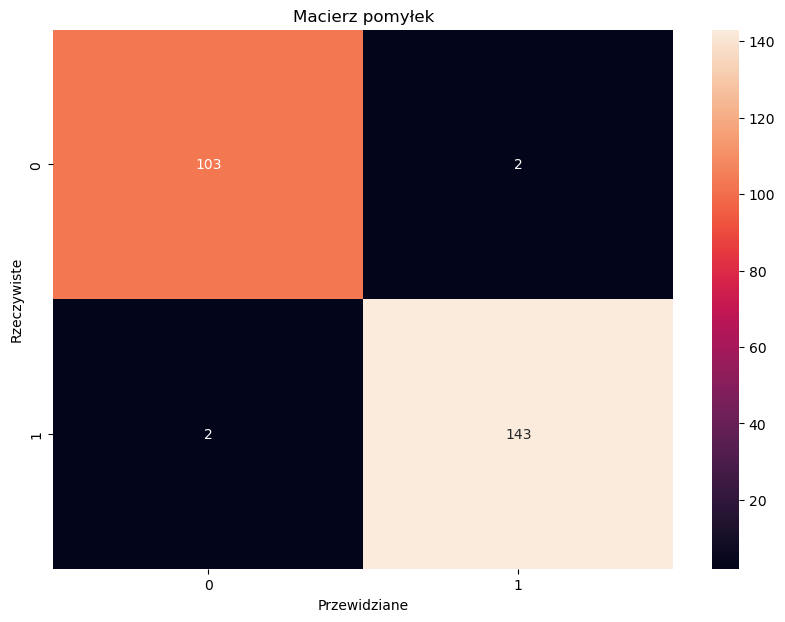

In [43]:
cm = confusion_matrix(y_test,predictions_new) # macierz pomylek
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Przewidziane')
plt.ylabel('Rzeczywiste')
plt.title('Macierz pomyłek')
plt.show()

TP = 143

TN = 103

FP = 2 (Blad I rodzaju)

FN = 2 (Blad II rodzaju)

In [44]:
print(classification_report(y_test,predictions_new)) #statystyki modelu

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       105
           1       0.99      0.99      0.99       145

    accuracy                           0.98       250
   macro avg       0.98      0.98      0.98       250
weighted avg       0.98      0.98      0.98       250



1. Precision (precyzja): 

- dla klasy 0 (zdrowy) - 98% przypadków, które model sklasyfikowal jako zdrowe jest poprawne
- dla klasy 1 (chory) - 99% przypadków, które mode zaklasyfikowal jako chore jest poprawne

2. Recall (czułość, sensitive)

- Klasa 0: model zidentyfikowal 98% wszystkich zdrowych osob
- Klasa 1: model zidentyfikowal 99% wszystkich chorych osób

3. F1-score (srednia harmoniczna precyzji i czulosci):

- Klasa 0: 0.98
- Klasa 1: 0.99

4. Accuracy (dokladnosc, R^2):

    Calkowita dokladnosc wynosi 98%

Wyswietlmy sobie dodatkowo dokladniejsze statystyki R^2 naszego modelu


In [45]:
Logreg_new.score(new_X_train,y_train) # doklaniejsze r2 dla zbioru treningowego

0.9653333333333334

In [46]:
Logreg_new.score(new_X_test,y_test) # dokladniejsze r2 dla zbioru testowego

0.984

Jak widzimy jest delikatna roznica miedzy dokladnoscia na zestawie uczacym i testowym, odziwo na testowym jest delikatnie wyzszy. Wartosci sa mocno zblizone, tak wiec mozna by na poczatku wnioskowac jakis underfitting, jednak no sa to wartosci zblizone bezblednosci, dlatego dobrze by bylo miec wiekszy zbior danych do przetestowania. Czysto teoretycznie mozna by sie pokusic o zastosowanie jakies walidacji krzyzowej, ale to moze w innym czasie. Przed koncem pobawimy sie jeszcze regularyzacja. Funkcja LogisticRegression stosuje cos takiego jak regularyzacja L2. W wielkim skrocie regularyzacja L2 kontroluje nadmierne dopasowanie modelu do danych poprzez zredukowanie wplywu poszczegolnych cech. W naszej funkcji zmieniamy nasza restrykcje manipulujac parametrem C. Domyslnie ustawione jest C = 1. Dajac mniejsze C, sprawimy ze waga naszych cech zostanie zblizona 0, znowu na odwrot, duze C sprawi ze od tego 0 powinny sie te wagi oddalac. Idealnie zobaczymy jak to dziala patrzac pozniej na wykres.

In [47]:
Logreg100_new = LogisticRegression(C=100).fit(new_X_train,y_train) # oslabienie regularyzacji (L2) 

In [48]:
predictions100_new = Logreg100_new.predict(new_X_test)

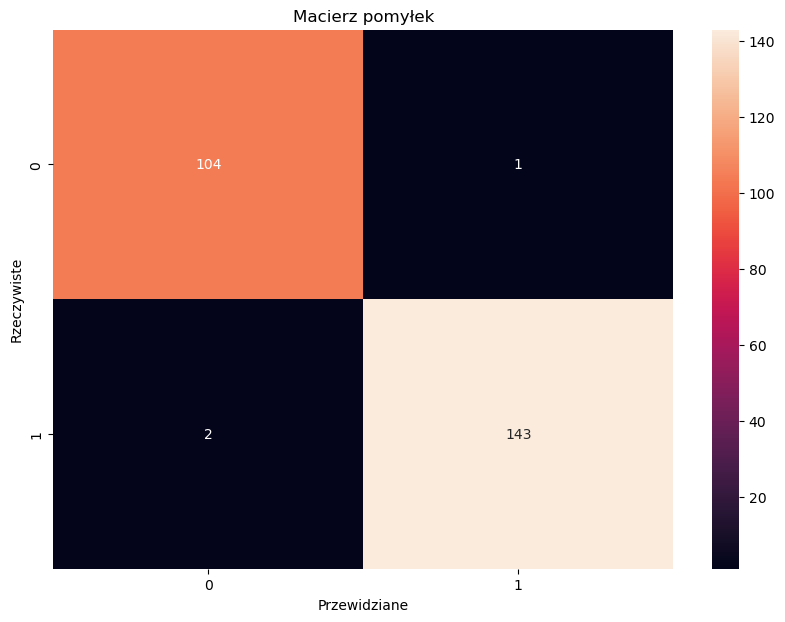

In [49]:
cm = confusion_matrix(y_test,predictions100_new) # macierz pomylek
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Przewidziane')
plt.ylabel('Rzeczywiste')
plt.title('Macierz pomyłek')
plt.show()

TP = 143

TN = 104

FP = 2

FN = 1

In [50]:
print(classification_report(y_test,predictions100_new))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       105
           1       0.99      0.99      0.99       145

    accuracy                           0.99       250
   macro avg       0.99      0.99      0.99       250
weighted avg       0.99      0.99      0.99       250



1. Precision (precyzja): 

- dla klasy 0 (zdrowy) - 98% przypadków, które model sklasyfikowal jako zdrowe jest poprawne
- dla klasy 1 (chory) - 99% przypadków, które model zaklasyfikowal jako chore jest poprawne

2. Recall (czułość, sensitive)

- Klasa 0: model zidentyfikowal 99% wszystkich zdrowych osob
- Klasa 1: model zidentyfikowal 99% wszystkich chorych osób

3. F1-score (srednia harmoniczna precyzji i czulosci):

- Klasa 0: 0.99
- Klasa 1: 0.99

4. Accuracy (dokladnosc, R^2):

    Calkowita dokladnosc wynosi 99%



Zwiekszylismy nasze C do 100 i model ulegl delikatnej poprawie, wiadomo, ze nie sa to jakies cuda, ale zawsze te liczby jakos w gore poszly, ale zawsze ten pojedyczny przypadek sklasyfikowalismy lepiej.

In [51]:
Logreg100_new.score(new_X_train,y_train) # doklaniejsze r2 dla zbioru treningowego

0.968

In [52]:
Logreg100_new.score(new_X_test,y_test)# dokladniejsze r2 dla zbioru testowego

0.988

Dla sportu, sprawdzmy jeszcze co sie stanie kiedy wtedy nadmiernie zmniejszymy ten nasz parametr, powiedzmy do 0.001

In [53]:
Logreg001_new = LogisticRegression(C=.001).fit(new_X_train,y_train) # silniejsza regularyzacja, wagi blizej 0

In [54]:
predictions001_new = Logreg001_new.predict(new_X_test)

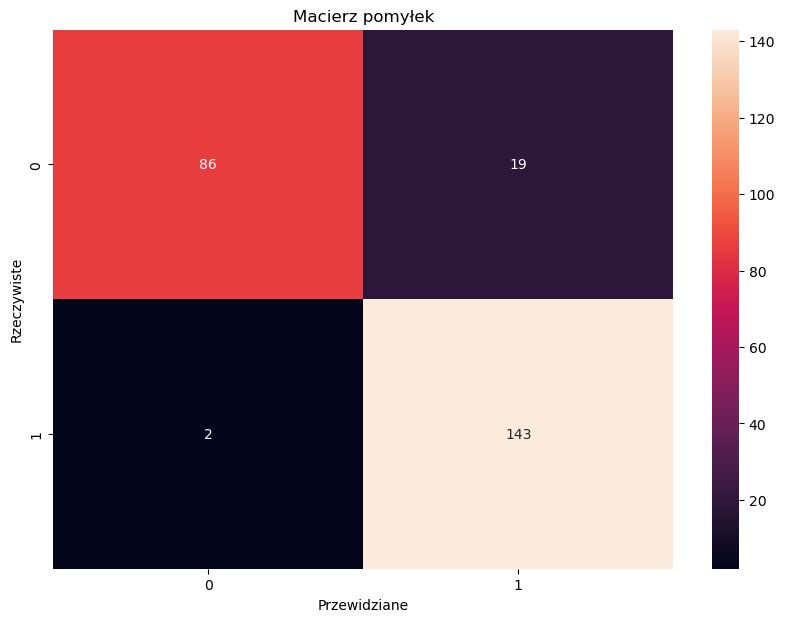

In [55]:
CM = confusion_matrix(y_test,predictions001_new) # macierz pomylek
plt.figure(figsize=(10,7))
sns.heatmap(CM, annot=True, fmt='d')
plt.xlabel('Przewidziane')
plt.ylabel('Rzeczywiste')
plt.title('Macierz pomyłek')
plt.show()

TP = 143

TN = 86

FP = 2

FN = 19

In [56]:
print(classification_report(y_test,predictions001_new))

              precision    recall  f1-score   support

           0       0.98      0.82      0.89       105
           1       0.88      0.99      0.93       145

    accuracy                           0.92       250
   macro avg       0.93      0.90      0.91       250
weighted avg       0.92      0.92      0.91       250



1. Precision (precyzja): 

- dla klasy 0 (zdrowy) - 98% przypadków, które model sklasyfikowal jako zdrowe jest poprawne
- dla klasy 1 (chory) - 88% przypadków, które mode zaklasyfikowal jako chore jest poprawne

2. Recall (czułość, sensitive)

- Klasa 0: model zidentyfikowal 82% wszystkich zdrowych osob
- Klasa 1: model zidentyfikowal 99% wszystkich chorych osób

3. F1-score (srednia harmoniczna precyzji i czulosci):

- Klasa 0: 0.89
- Klasa 1: 0.93

4. Accuracy (dokladnosc, R^2):

    Calkowita dokladnosc wynosi 92%



Jak widac tu juz troche polecielismy w dol. Glownie cierpimy tutaj na TP. Nasz model popelnia wiecej bledow pierwszego rodzaju, co oznacza ze nie wszystkie osoby, ktore klasyfikuje jako chore, rzeczywiscie takie sa.

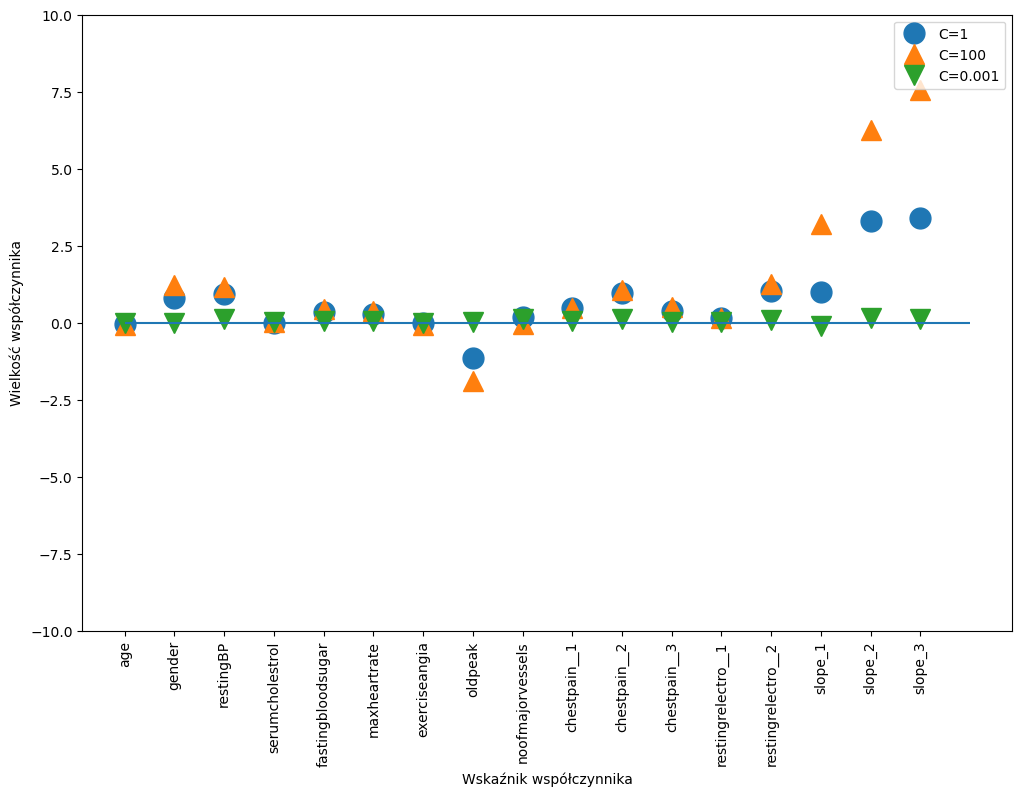

In [57]:
plt.figure(figsize=(12, 8))
plt.plot(Logreg_new.coef_.T, 'o', label="C=1",markersize=15)
plt.plot(Logreg100_new.coef_.T, '^', label="C=100",markersize=15)
plt.plot(Logreg001_new.coef_.T, 'v', label="C=0.001",markersize=15)
plt.xticks(range(X_train.shape[1]), X_train.columns, rotation=90)
plt.hlines(0, 0, X_train.shape[1])
plt.ylim(-10, 10)
plt.xlabel("Wskaźnik współczynnika")
plt.ylabel("Wielkość współczynnika")
plt.legend()

Mamy przed soba wykres, ktory mowi nam o wielkosci wplywu kazdego wspolczynnika na nasze modele. Jak widac w legendzie mamy wyszczegolnione wszystkie 3 sytuacje ktore testowalismy. Zielonym trojkatem mamy oznaczona sytuacje gdzie ustawilismy parametr C na 0.001 i jak widac, prakycznie wszystkie wspolczynniki sa bardzo bliskie zeru. Im ta regularyzacja jest mniejsza, tym te nasze wspolczynniki oddalaja sie od osi X.

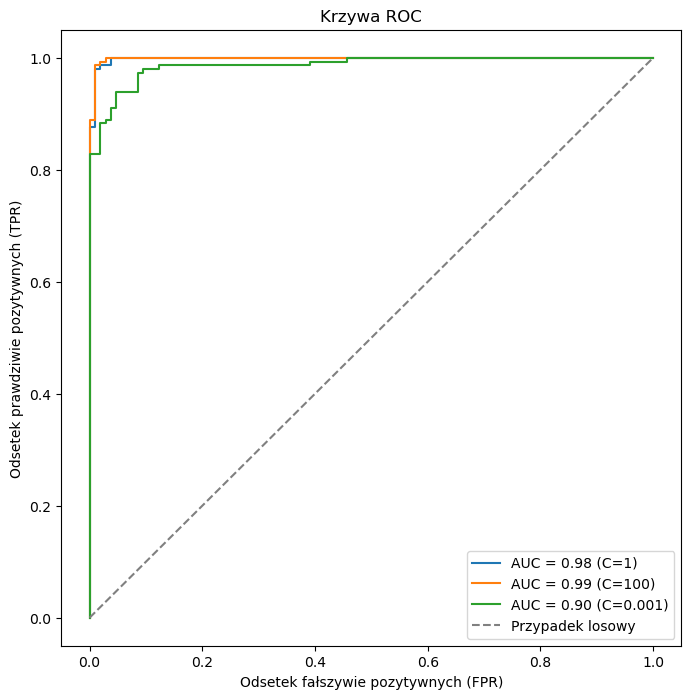

In [58]:
y_pred_proba_new = Logreg_new.predict_proba(new_X_test)[:,1]
y_pred_proba100_new = Logreg100_new.predict_proba(new_X_test)[:,1]
y_pred_proba001_new = Logreg001_new.predict_proba(new_X_test)[:,1]

roc_auc_new = roc_auc_score(y_test, predictions_new)
roc_auc100_new = roc_auc_score(y_test, predictions100_new)
roc_auc001_new = roc_auc_score(y_test, predictions001_new)

fpr_new, tpr_new, thresholds_new = roc_curve(y_test, y_pred_proba_new)
fpr100_new, tpr100_new, thresholds100_new = roc_curve(y_test, y_pred_proba100_new)
fpr001_new, tpr001_new, thresholds001_new = roc_curve(y_test, y_pred_proba001_new)

plt.figure(figsize=(8, 8))
plt.plot(fpr_new, tpr_new, label=f'AUC = {roc_auc_new:.2f} (C=1)')
plt.plot(fpr100_new, tpr100_new, label=f'AUC = {roc_auc100_new:.2f} (C=100)')
plt.plot(fpr001_new, tpr001_new, label=f'AUC = {roc_auc001_new:.2f} (C=0.001)')
plt.plot([0, 1], [0, 1], '--', color='gray', label='Przypadek losowy')
plt.xlabel('Odsetek fałszywie pozytywnych (FPR)')
plt.ylabel('Odsetek prawdziwie pozytywnych (TPR)')
plt.title('Krzywa ROC')
plt.legend()
plt.show()

Tutaj rowniez w formie takiego malego podsumowania nasza krzywa ROC. Jak widzimy nawieksze pole pod wykresem mamy pod funkcja z parametrem C = 100, a najmniejsze gdy C bylo rowne 0.001.

Podsumowanie: Nasz model w najlepszej wersji jest praktycznie bezbledny na zbiorze testowym. wskazuje ludzi chorych z precyzja na wysokosci 99%, a ludzi zdrowych 98%. Dobrze by bylo poddac ten algorytm wiekszej ilosci testow, tak aby potwierdzic skutecznosc jego dzialania. Tak jak wspominalismy wczesniej mozna by pokusic sie o zastosowanie walidacji krzyzowej. Dodatkowo mozna by jeszcze dokladnie przyjrzec sie przypadkom, w ktorych nasz model sie myli, poniewaz moze nam to dostarczyc dodatkowych informacji, ktore jeszcze by mogly pomoc w poprawie naszego modelu.